In [1]:
# installing open datasets
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
# Define path of dataset from kaggle
dataset ='https://www.kaggle.com/datasets/kayvanshah/eye-dataset'

In [4]:
# downloading dataset
od.download(dataset)

Skipping, found downloaded files in ".\eye-dataset" (use force=True to force download)


In [5]:
# importing the libraries
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
# assigning dataset path to variable
dataset_dir ='eye-dataset/Eye dataset'

In [7]:
#printing list of classes in dataset
print(os.listdir(dataset_dir))

['close_look', 'forward_look', 'left_look', 'right_look']


In [8]:
# defining parameters
batch_size = 32
img_height = 160
img_width = 160

In [9]:
# installing tensorflow
!pip install --user tensorflow

In [10]:
#splitting training data
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14360 files belonging to 4 classes.
Using 11488 files for training.


In [11]:
# splitting validation data
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14360 files belonging to 4 classes.
Using 2872 files for validation.


In [12]:
# printing class names under train data
class_names = train_ds.class_names
print(class_names)

['close_look', 'forward_look', 'left_look', 'right_look']


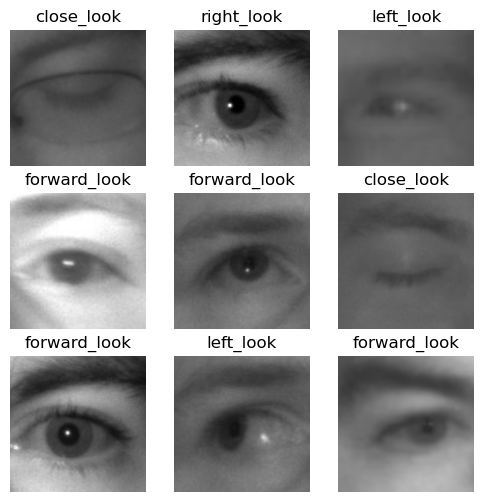

In [13]:
# data visualization : printing the images
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
#tensor of the shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [15]:
#dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#Standardize the data: normalization
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.17304006 0.79906875


In [19]:
#Create the model
from keras.models import Sequential
num_classes = 4
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
#compile the model:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,736,484 (6.62 MB)

 Trainable params: 1,736,484 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - accuracy: 0.6501 - loss: 0.7732 - val_accuracy: 0.9408 - val_loss: 0.1920
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 176ms/step - accuracy: 0.9432 - loss: 0.1800 - val_accuracy: 0.9645 - val_loss: 0.1240
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 62s 174ms/step - accuracy: 0.9622 - loss: 0.1237 - val_accuracy: 0.9624 - val_loss: 0.1498
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 66s 184ms/step - accuracy: 0.9710 - loss: 0.0960 - val_accuracy: 0.9718 - val_loss: 0.0937
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 138s 386ms/step - accuracy: 0.9817 - loss: 0.0645 - val_accuracy: 0.9690 - val_loss: 0.1030


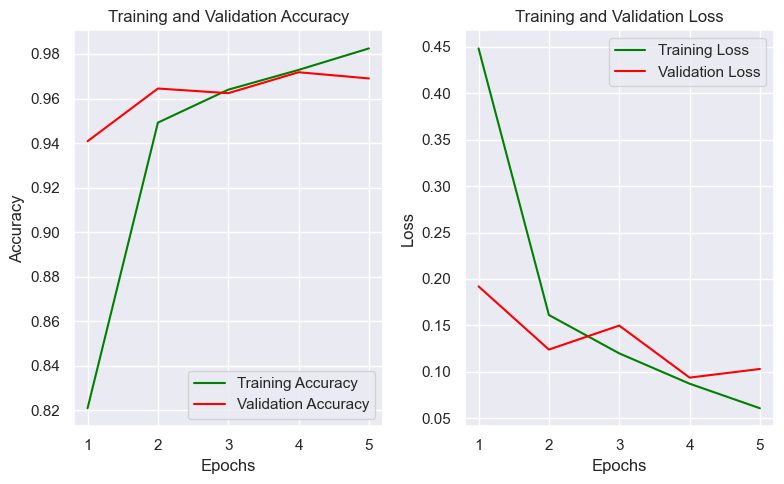

In [23]:
#Accuracy and epchos grach
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)  # Use the length of loss or acc

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='green')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
#loss and accuracy of train dataset
loss,accuracy = model.evaluate(train_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")     

359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9760 - loss: 0.0736
Loss: 0.07397397607564926
Accuracy: 0.9759749174118042


In [25]:
#loss and accuracy of validation dataset
loss,accuracy = model.evaluate(validation_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")  

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9682 - loss: 0.0938
Loss: 0.10304951667785645
Accuracy: 0.969011127948761


In [26]:
#possibile probability
y_pred_probabilities = model.predict(train_ds)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_pred_classes[:15]

359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step


array([1, 2, 2, 1, 3, 3, 0, 0, 1, 2, 1, 3, 0, 1, 0], dtype=int64)

In [29]:
from sklearn.metrics import classification_report
class_names = ['close_look', 'forward_look', 'left_look', 'right_look']  # Replace [...] with your class names
true_labels = []
for images, labels in validation_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
# Obtain predicted labels
y_pred_probabilities = model.predict(validation_ds)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Print classification report
print(classification_report(true_labels, y_pred_classes, target_names=class_names))




90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
              precision    recall  f1-score   support

  close_look       1.00      0.99      0.99       762
forward_look       0.98      0.91      0.94       693
   left_look       0.98      0.98      0.98       709
  right_look       0.92      0.99      0.95       708

    accuracy                           0.97      2872
   macro avg       0.97      0.97      0.97      2872
weighted avg       0.97      0.97      0.97      2872



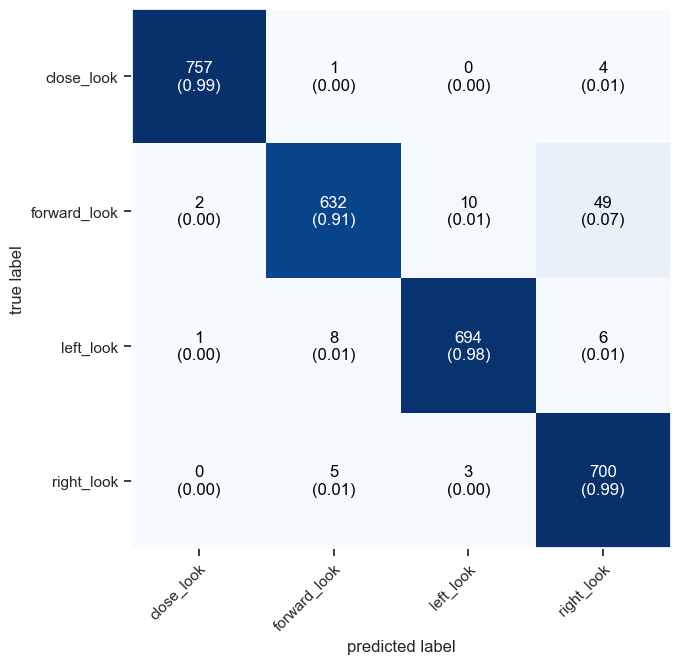

In [32]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=conf_matrix, figsize=(8, 7), class_names=class_names, show_normed=True)
plt.show()